In [2]:
from scipy.constants import c
import numpy as np
from numpy.lib import recfunctions as rec
from astropy.io          import fits
from astropy.coordinates import SkyCoord, Angle, search_around_sky
from astropy             import units as u
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
import pandas as pd
import math
from tqdm.notebook import tqdm
from scipy.optimize import minimize
import emcee
from iminuit import Minuit
import iminuit 
from scipy.special import erf

In [7]:
#The los gaussian can be so extended that the erf is needed to normalize appropriately, as applied below.
def background_gaussian(velocity, richness, total_sigma):
    vmax = 3e6 * (richness / 20.0) ** 0.45  # m/s
    z = vmax*(0.5**0.5)/total_sigma
    normalization = 1/erf(z)
    gaussian = np.exp(-0.5*((velocity/total_sigma)**2))/(np.sqrt(2*np.pi)*total_sigma)
    return_arr = normalization * gaussian

    outside_cut = np.where(np.abs(velocity) > vmax)[0]
    if len(outside_cut) > 0:
        print("UH OH: VELOCITY DATA FED INTO MCMC IS OUTSIDE CUT")
        return_arr[outside_cut] = 0

    return return_arr

In [8]:
def nlnlike4(parameters):
    """
    The log-likelihood function. Note the use of globals, which is a no-no but preferrable to passing five
    arguments here. Just be careful that you've defined these global variables appropriately prior
    to calling the function"""

    global velocity,richness,zcen,sigma_obs
    
    z_p = np.median(zcen)
    lambda_p = np.median(richness)

    f_bound, lnsp_bound, lnsp_los, alpha, beta = parameters #unpacking parameters

    bound_sigmav = np.exp(lnsp_bound)*(((1+zcen)/(1+z_p))**beta)*((richness/lambda_p)**alpha)
    bound_sigmat = (bound_sigmav**2 + sigma_obs**2)**0.5
    bound_gaussian = np.exp(-0.5*((velocity/bound_sigmat)**2))/(np.sqrt(np.pi*2)*bound_sigmat)

    los_sigmav = np.exp(lnsp_los)
    los_sigmat = (los_sigmav**2 + sigma_obs**2)**0.5
    los_gaussian = background_gaussian(velocity, richness, los_sigmat)
#    if 0.05 < alpha < 1 and -2 < beta < 2 and 0<f_bound<1 and 0<lnsp_bound<15 and 0<lnsp_los<20:
#        return -np.sum(np.log(f_bound*bound_gaussian+(1-f_bound)*los_gaussian))
#    else:
#        return -np.inf
    return -np.sum(np.log(f_bound*bound_gaussian+(1-f_bound)*los_gaussian))

In [9]:
def lnlike4(parameters):
    return -nlnlike4(parameters)

In [10]:
fname = "last_catalog.npy"
dt = np.load(fname)
pax=pd.DataFrame.from_records(dt.tolist(), columns=dt.dtype.names)

In [11]:
#Reshape the catalog into a nice dataframe
rich=pax.LAMBDA_CHISQ
zcen=pax.BCG_SPEC_Z
r=pax.R/pax.R_LAMBDA
v=pax.Velocity
ra=pax.MEM_RA
dec=pax.MEM_DEC
sigma_obs = c*((pax.ZMEM_ERR**2 + pax.ZCEN_ERR**2)**(0.5))
pax=pd.DataFrame({'rich':rich,'zcen':zcen,'r':r,'v':v,'ra':ra,'dec':dec,'sigma_obs':sigma_obs});
df=pax

In [12]:
nbins=1000

In [13]:
radial_bins=np.linspace(0.2,4.8,24)

In [14]:
rbin_centers = (radial_bins[:-1] + radial_bins[1:])/2.

In [15]:
parameters=np.zeros( (24,5) )
errors=np.zeros( (24,5) )

In [16]:
df_full=df
count = 0
min=np.array([0.1,9,14,0,-1])
max=np.array([1,15,20,1,1])

bnds=[(x,y) for x, y in zip(min, max)]
#For each radial bin defined above, slice the dataframe and model the galaxies in it. Return the parameters
#in two vectors, parameters[] and errors[]

for i in radial_bins:

    df_bin=df.loc[ (df.r > i) & (df.r <= i+0.2) ].copy()

#note these are globals being implicitly passed to the function    
    velocity = df_bin.v
    richness = df_bin.rich
    zcen = df_bin.zcen
    sigma_obs=df_bin.sigma_obs
    
    m = Minuit.from_array_func(nlnlike4, np.array([0.3,13,30,0.45,-0.4]),limit=bnds,errordef=1.0,pedantic=False)
    m.migrad()
    p=m.fitarg['x0']
    lnsigma_p=m.fitarg['x1']
    lnsigma_los=m.fitarg['x2']
    alpha=m.fitarg['x3']
    beta=m.fitarg['x4']

    dp=m.fitarg['error_x0']
    dlnsigma_p=m.fitarg['error_x1']
    dlnsigma_los=m.fitarg['error_x2']
    dalpha=m.fitarg['error_x3']
    dbeta=m.fitarg['error_x4']
    
    parameters[count]=[p,lnsigma_p,lnsigma_los,alpha,beta]
    errors[count]=[dp,dlnsigma_p,dlnsigma_los,dalpha,dbeta]
    print(i,i+0.2,parameters[count])
    count = count + 1

0.2 0.4 [ 0.92769865 13.45252903 19.85377299  0.43729378  0.21279682]
0.4 0.6000000000000001 [ 0.89481467 13.3886608  15.33966574  0.4259698  -0.32471878]
0.6 0.8 [ 0.86957406 13.34000717 19.23330229  0.42906801  0.56424632]
0.8 1.0 [ 0.78971192 13.24625201 15.3743682   0.39988311  0.80042404]
1.0 1.2 [ 0.71933741 13.21011833 15.0521557   0.47860784  0.32966874]
1.2 1.4 [ 0.66757866 13.16820925 15.26042383  0.44301874  0.99995903]
1.4 1.5999999999999999 [ 0.58922987 13.1325033  15.23649697  0.35572893 -0.13675969]
1.5999999999999999 1.7999999999999998 [ 0.57711444 13.12018398 15.39203076  0.20080581  0.43867999]
1.7999999999999998 1.9999999999999998 [5.46614326e-01 1.31216524e+01 1.53508678e+01 3.16413042e-01
 1.16046350e-02]
1.9999999999999998 2.1999999999999997 [ 0.46219059 13.00548963 14.9759401   0.34105899 -0.21488195]
2.1999999999999997 2.4 [ 0.49034451 13.02726651 15.1803258   0.37430775 -0.93266154]
2.4 2.6 [ 0.43514725 12.93169222 15.21304737  0.27857582  0.26770825]
2.6 2.800

In [17]:
#grab the appropraite parameter you wish to graph. Here I grab the fraction of dynamically associated galaxies,
#and the variance of their velocity

f_da=[ x[0] for x in parameters]
f_errors=[x[0] for x in errors]
sig_p=[ x[1] for x in parameters]
sig_error=[ x[1] for x in errors]

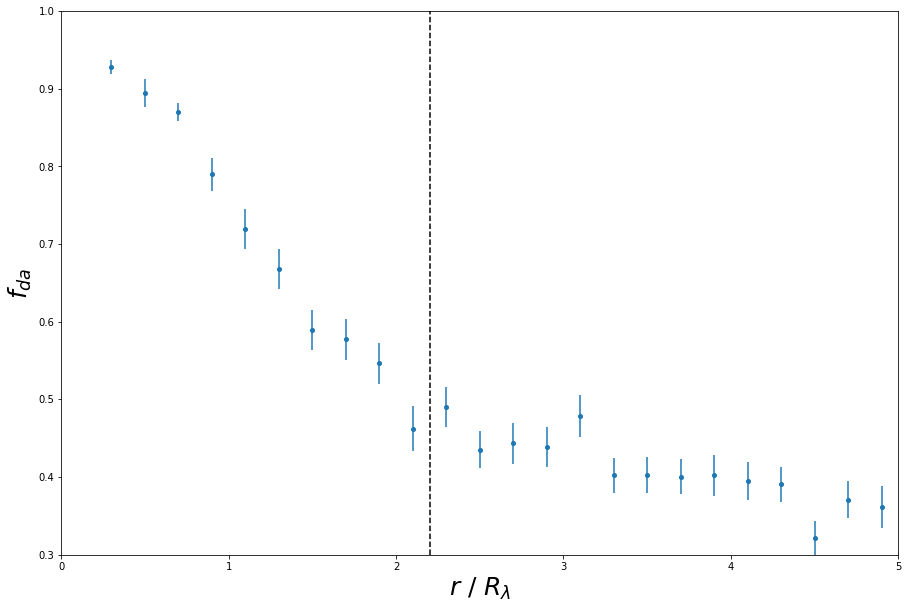

In [18]:
fig,(ax1) = plt.subplots(1, 1,figsize=(15,10))
ax1.errorbar(radial_bins+0.1, f_da, yerr=f_errors, fmt='o',markersize=4)
ax1.set_xlabel('$r$ / $R_{\lambda}$')
ax1.set_ylabel('$f_{da}$')
ax1.xaxis.label.set_size(25)
ax1.yaxis.label.set_size(25)
ax1.set_ylim(0.3,1)
ax1.set_xlim(0,5)
plt.axvline(x=2.2, color='k', linestyle='--')

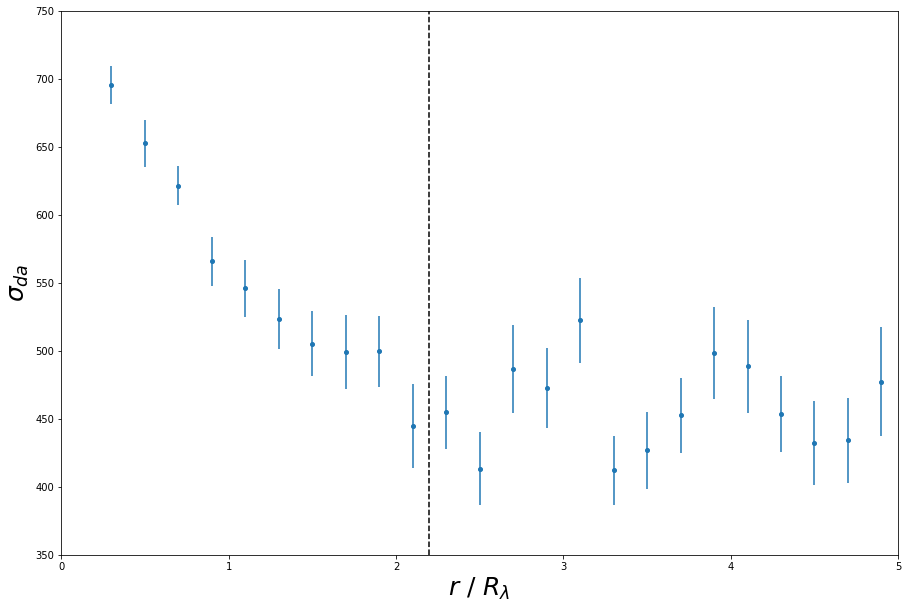

In [19]:
fig,(ax1) = plt.subplots(1, 1,figsize=(15,10))
ax1.errorbar(radial_bins+0.1, np.exp(sig_p)/1000, yerr=np.exp(sig_p)/1000*sig_error, fmt='o',markersize=4)
ax1.set_xlabel('$r$ / $R_{\lambda}$')
ax1.set_ylabel('$\sigma_{da}$')
ax1.xaxis.label.set_size(25)
ax1.yaxis.label.set_size(25)
ax1.set_ylim(350,750)
ax1.set_xlim(0,5)
plt.axvline(x=2.2, color='k', linestyle='--')

Below, code to check the model fit for some radial bin. Start minuit at the np.array and minimize, then reproduce the fit via sampling. The array given by m.np_values() is the parameter fit; the errors are stored in a dictionary object m.errors.

In [20]:
#note copy() here so you don't still point to the original df
df_bin=df.loc[ (df.r > 1.8) & (df.r <= 2.0) ].copy()

velocity = df_bin.v
richness = df_bin.rich
zcen = df_bin.zcen
sigma_obs=df_bin.sigma_obs

#minuit_model=iminuit.minimize(nlnlike2, np.array([0.3,13,30,0.45,-0.4]), args=(x,richness,zcen))
m = Minuit.from_array_func(nlnlike4, np.array([0.3,13,30,0.45,-0.4]),limit=bnds,errordef=0.5,pedantic=False)
m.migrad()

p, lnsigma_p, lnsigma_los, alpha, beta = m.np_values()

In [21]:
m.np_values()

array([5.46690461e-01, 1.31218585e+01, 1.53514278e+01, 3.16543579e-01,
       9.56800032e-03])

In [22]:
m.errors

<ErrorView of Minuit at 55cef358f750>
  x0: 0.0187059219762013
  x1: 0.03697723005204967
  x2: 0.17637863491071126
  x3: 0.07743891061006003
  x4: 0.5555194113761446

In [23]:
z_p = np.median(zcen)
lambda_p = np.median(richness)
nrepeat=10000
sigma_d = np.exp(lnsigma_p)*(((1+zcen)/(1+z_p))**beta)*((richness/lambda_p)**alpha)
randv=np.random.normal(0,np.repeat(sigma_d,nrepeat))/np.repeat(sigma_d,nrepeat)
bin_count,bin_centers=np.histogram(randv,bins=nbins)

In [24]:
bin_width=np.histogram(randv,bins=nbins)[1][1] - np.histogram(randv,bins=nbins)[1][0]

In [25]:
vmax=3e6 * (richness / 20.0) ** 0.45

In [32]:
sigma_los=np.exp(lnsigma_los)
sigma_los_vector=np.repeat(sigma_los,len(sigma_d))
just_p=np.random.normal(0,np.repeat(sigma_los_vector,nrepeat))/np.repeat(sigma_d,nrepeat)
pbin_count,pbin_centers=np.histogram(just_p,bins=bin_centers)

In [33]:
hist, bin_edges = np.histogram(df_bin.v/sigma_d,bins=bin_centers)

In [34]:
pbin_count=pbin_count*np.mean(1/erf(vmax/sigma_los))
#Note that this is an imperfect way of reconstructing the plot. However, the fit is correct, and the correct
#resampling and visualiation is done for the 3-population model (my next code)

Text(0, 0.5, 'P($v$ / $\\sigma_{v,orb})$')

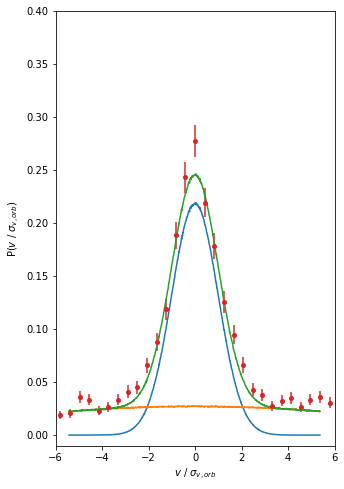

In [35]:
fig,(ax1) = plt.subplots(1, 1,figsize=(5,8))
#plt.scatter(x/sigma_d, bin_width*len(x)*model, label = 'fit', alpha=0.2)
ax1.plot(bin_centers[0:len(bin_count)],p*bin_count/nrepeat/bin_width/len(velocity));
ax1.plot(pbin_centers[0:len(bin_count)],(1-p)*pbin_count/nrepeat/bin_width/len(velocity));
ax1.plot(pbin_centers[0:len(bin_count)],(p*bin_count+(1-p)*pbin_count)/nrepeat/bin_width/len(velocity));
bin_edges = np.linspace(-6,6,30)
counts,bin_edges = np.histogram(df_bin.v/sigma_d,bin_edges)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
bin_width2=bin_centres[2]-bin_centres[1]
ax1.errorbar(bin_centres, counts/bin_width2/len(df_bin.v), yerr=np.sqrt(counts)/bin_width2/len(df_bin.v), fmt='o',markersize=4)
ax1.set_xlim([-6, 6])
ax1.set_ylim([-0.01, 0.4])
ax1.set_xlabel('$v$ / $\sigma_{v,orb}$')
ax1.set_ylabel('P($v$ / $\sigma_{v,orb})$')

Minuit plots countours/corner plots via an embedded method (ie without sampling)

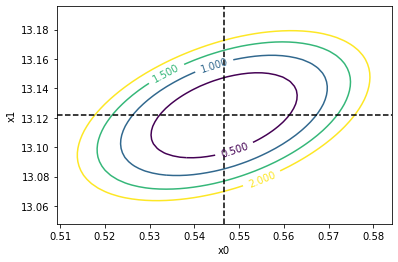

In [38]:
m.draw_contour('x0', 'x1');
#compare this to the top-left picture of the corner plot below.

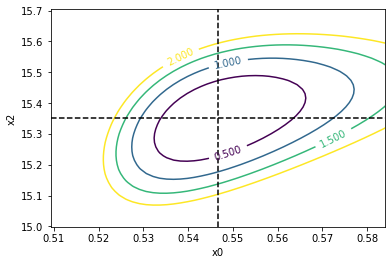

In [39]:
m.draw_contour('x0', 'x2');
#compare this to the middle-left picture of the corner plot below.

Below, for the purposes of comparison, run an emcee chain on the model. It should be the case that, if you start the chains at the minuit value, it doesn't move. If you start the model elsewhere, it should converge to the minuit values. The goal is to have a deterministic AND a non-deterministic algorithm saying you've converged. And, to not wait hours for convergence :)

In [53]:
#Now I begin to sample from our parameter space of good likelihood and run the MCMC.
ndim, nwalkers = 5,30
#This generates a list of 30 walkers each 4D in the parameter space of high likelihood
origin = [0.3,13,14,0.45,-0.4] #I have good guesses for where my parameters should end up
scale = [0.02, 0.1, 0.1,0.02, 0.02]
pos = [origin + scale*np.random.randn(ndim) for i in range(nwalkers)]
#Now I set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike4)
sampler.run_mcmc(pos, 1000); #run a 1000 length chain starting at pos

In [54]:
#Getting the values that maximize likelihood
flat_chain = np.concatenate(sampler.chain)
flat_lnprobs = np.concatenate(sampler.lnprobability)
max_prob_idx = np.argmax(flat_lnprobs)
max_prob = flat_lnprobs[max_prob_idx]
p, lnsigma_p, lnsigma_los,alpha, beta = flat_chain[max_prob_idx]
flat_chain[max_prob_idx]

array([ 0.54429159, 13.1272778 , 15.3440833 ,  0.31188415, -0.03669965])

In [55]:
flat_chain[max_prob_idx]-m.np_values()
#our models are identical to the third sig fig...

array([-0.00239887,  0.00541928, -0.00734446, -0.00465943, -0.04626765])

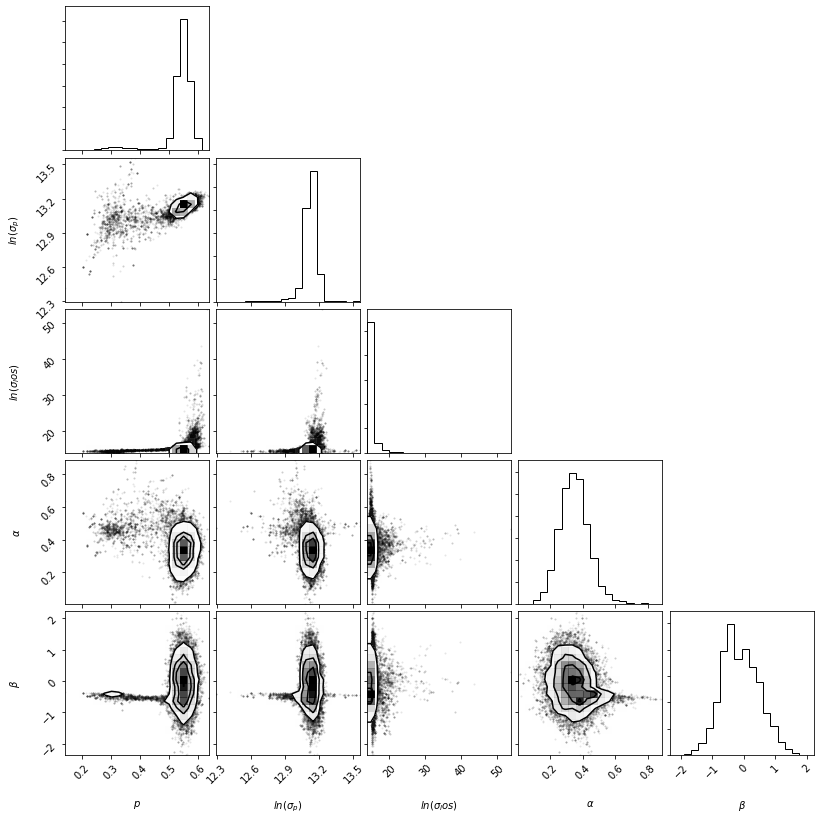

In [56]:
import corner
chain_burn=sampler.chain
samples = chain_burn.reshape((-1, 5))
fig = corner.corner(samples, labels=["$p$", "$ln(\sigma_p)$", "$ln(\sigma_los)$","$\\alpha$", "$\\beta$"])

In [65]:
def fractions(samples):
    """
    Plotting f_vir and f_bound versus R/Rt.
    Figure 4 in the paper, left pane."""
    a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, x_p, alpha_x, beta_x = samples
    b0 = 1 + a1 + a2 #calculated from constraint equations
    c0 = -(c1 + c2) #calculated from constraint equations
    r_by_rt = np.tile(np.linspace(0, X_BY_XT_MAX, 100), (len(samples[0]), 1))

    #assuming all are outside x_p
    f_bound = b0[:,None] + b1[:,None]*(r_by_rt-1)
    f_vir = np.zeros_like(r_by_rt)

    lt_xt = np.where(r_by_rt <= 1)
    lt_xt = np.unique(lt_xt[1])
    #properly reassign those that are actually inside
    f_bound[:,lt_xt] = 1 + a1[:,None]*r_by_rt[:,lt_xt] + a2[:,None]*(r_by_rt[:,lt_xt]**2)
    f_vir[:,lt_xt] = c0[:,None] + c1[:,None]*r_by_rt[:,lt_xt]+ c2[:,None]*(r_by_rt[:,lt_xt]**2)

    bound_means = np.mean(f_bound, axis=0)
    bound_sigmas = np.std(f_bound, axis=0)
    bound_top = bound_means + bound_sigmas
    bound_bottom = bound_means - bound_sigmas

    vir_means = np.mean(f_vir, axis=0)
    vir_sigmas = np.std(f_vir, axis=0)
    vir_top = vir_means + vir_sigmas
    vir_bottom = vir_means - vir_sigmas
    
    bnd = plt.fill_between(r_by_rt[0], bound_top, bound_bottom)
    vir = plt.fill_between(r_by_rt[0], vir_top, vir_bottom)
    plt.legend((bnd, vir), (r"$f_{\rm{da}}$",r"$f_{\rm{orb}}$"))
    plt.ylabel(r"$f_{\rm{orb}},f_{\rm{da}}$")
    plt.ylim(0, 1)
    plt.yticks(np.linspace(0, 1, 6))
    plt.xlabel(r"$R/R_{\rm{edge}}$")
    plt.xlim(0, 2.5)
    plt.xticks(np.linspace(0, 2.5, 6))
    plt.show()

In [60]:
def sample_chain(num_draws):
    """
    This function samples from the properly burned
    chain (posterior) to get a Bayesian realization
    num_draws times."""
    chain = np.load("chain_samples.npy")

    draws = np.random.randint(len(chain), size=num_draws) #the indices to draw
    return chain[draws].T #should have dimensions of (NDIM, num_draws) so each row is one variable

In [63]:
X_BY_XT_MAX = 2.5
samples = sample_chain(2000) #500 for a good band

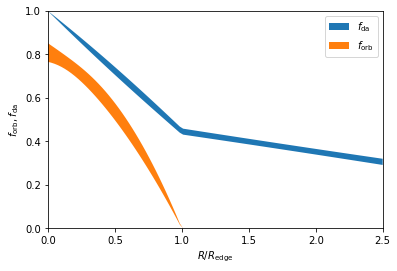

In [66]:
fractions(samples)